# Tutorial: detecting heads using ssd_head_keras
This is a brief tutorial that shows how to use our Single Shot Multibox Detector (SSD) based detector for head detection on images.

## 0. Setup
First, we import the libraries required to load images and setup the SSD head detector for inference. This model has been trained using [Pierluigi Ferrari's SSD implementation](https://github.com/pierluigiferrari/ssd_keras/), of which we include the required code in this repository. We refer you to the original implementation in case of an issue with that code.  

In [3]:
from platform import python_version
import subprocess
import os
from math import *

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

%matplotlib inline

Using TensorFlow backend.


Since there are differences in the object serialization methods used between Python versions previous to version 3.6, we provide two different versions of our model. In order to determine which version should be used, please run the following code:

In [4]:
py_version = ''.join(python_version().split('.'))
model_version = '3.6'
if int(py_version) < 360:
    model_version = '3.5'
print('Using model version for Python %s.' % model_version)

Using model version for Python 3.6.


This model uses a 512x512 input size, let's set our image size to that resolution size:

In [5]:
# Set the image size.
img_height = 512
img_width = 512

There are two different inference modes: the mode `inference` uses the original implementation's algorithm, and the `inference_fast` mode is faster but might produce different results. 

In [6]:
# Set the model's inference mode
model_mode = 'inference'

Finally, we set the model's confidence threshold value, i.e. the model will only output predictions above or equal to this value. Set a value in range [0, 1], where a higher value decreases the number of detections produced by the model and increases its speed during inference. 

We choose to set a low value (1%) for the model confidence threshold and then use a higher value at a later stage. 

In [7]:
# Set the desired confidence threshold
conf_thresh = 0.01

## 1. Load a trained SSD model
In order to run the head detection model first you must download the `.h5` file that contains the model and the trained weights. To do so, run the code in [section 1.1](#download_cell).

Once downloaded, you can either build a new model and load the trained weights into it ([section 1.2](#build_cell)) or just load the ready to use model ([section 1.3](#load_cell)). The first option allows you to configure some model parameters, while the latter loads the original model's configuration.

<a id='download_cell'></a>
### 1.1 Download the model's .h5 file
First, we download the model's file from the server to this repository's `data/models` directory. We provide a simple script which will do this task for you, which you can execute by running the next cell. NOTE: this script requires `curl`to be installed in your system. 

In case you prefer to download the model manually, you can download it using the following links:
 - [Python versions <= 3.5](https://drive.google.com/open?id=12cqKTPtQBAu780219hEbST7VwQuf6xDH).
 - [Python versions >= 3.6](https://drive.google.com/open?id=1vlmKOBtaT7eAd4_WcAv5MLBn7q_SWXoh).

<a id='build_cell'></a>
### 1.2 Build the model and load the trained weights into it
You can build a new model and load the provided weights into it, which allows some degree of personalization.

Or

<a id='load_cell'></a>
### 1.3 Load the model as-is
This option loads the downloaded model as it was compiled.  

In [8]:
# Make sure the path correctly points to the model's .h5 file
weights_path = './data/ssd512-hollywood-trainval-bs_16-lr_1e-05-scale_pascal-epoch-187-py3.6.h5'# % model_version

# Create an SSDLoss object in order to pass that to the model loader
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# Clear previous models from memory.
K.clear_session() 

# Configure the decode detections layer based on the model mode
if model_mode == 'inference':
    decode_layer = DecodeDetections(img_height=img_height,
                                    img_width=img_width,
                                    confidence_thresh=conf_thresh,
                                    iou_threshold=0.45,
                                    top_k=200,
                                    nms_max_output_size=400)
if model_mode == 'inference_fast':
    decode_layer = DecodeDetectionsFast(img_height=img_height,
                                        img_width=img_width,
                                        confidence_thresh=conf_thresh,
                                        iou_threshold=0.45,
                                        top_k=200,
                                        nms_max_output_size=400)
    
# Finally load the model
model = load_model(weights_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                 'L2Normalization': L2Normalization,
                                                 'DecodeDetections': decode_layer,
                                                 'compute_loss': ssd_loss.compute_loss})

tracking <tf.Variable 'conv4_3_norm/conv4_3_norm_gamma:0' shape=(512,) dtype=float32> gamma


## 2. Load example images

Load some images for which you'd like the model to make predictions. There are some demo images available in this repository's `examples`directory.

In [9]:
# Original images array
orig_images = [] 
# Resized images array
input_images = []

# We'll only load one image in this example.
img_path = 'examples/marwa.PNG'
# img_path = 'examples/fish_bike.jpg'
# img_path = 'examples/rugby_players.jpg'

# Load the original image (used to display results)
orig_images.append(image.load_img(img_path))

# Load the image resized to the model's input size
img = image.load_img(img_path, target_size=(img_height, img_width))

img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)
print(input_images.shape)

(1, 512, 512, 3)


## 3. Make predictions
Now we feed the example images into the network to obtain the predictions.

In [10]:
y_pred = model.predict(input_images)
y_pred

array([[[1.0000000e+00, 9.9992704e-01, 2.1860751e+02, 8.0240128e+01,
         2.7664035e+02, 2.3393221e+02],
        [1.0000000e+00, 2.8063731e-02, 2.2502290e+02, 8.0201172e+01,
         2.7036398e+02, 1.5604327e+02],
        [1.0000000e+00, 2.5656279e-02, 2.0052586e+02, 2.0527975e+02,
         2.2448442e+02, 2.8223221e+02],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]]], dtype=float32)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [11]:
confidence_threshold = 0.25

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   218.61  80.24 276.64 233.93]]


## 4. Visualize the predictions

We'd like to visualize the predictions on the image in its original size, so we transform the coordinates of the predicted boxes accordingly.

In [12]:
print(np.array(orig_images[0]).shape[1] / img_width)
print(np.array(orig_images[0]).shape)

2.18359375
(608, 1118, 3)


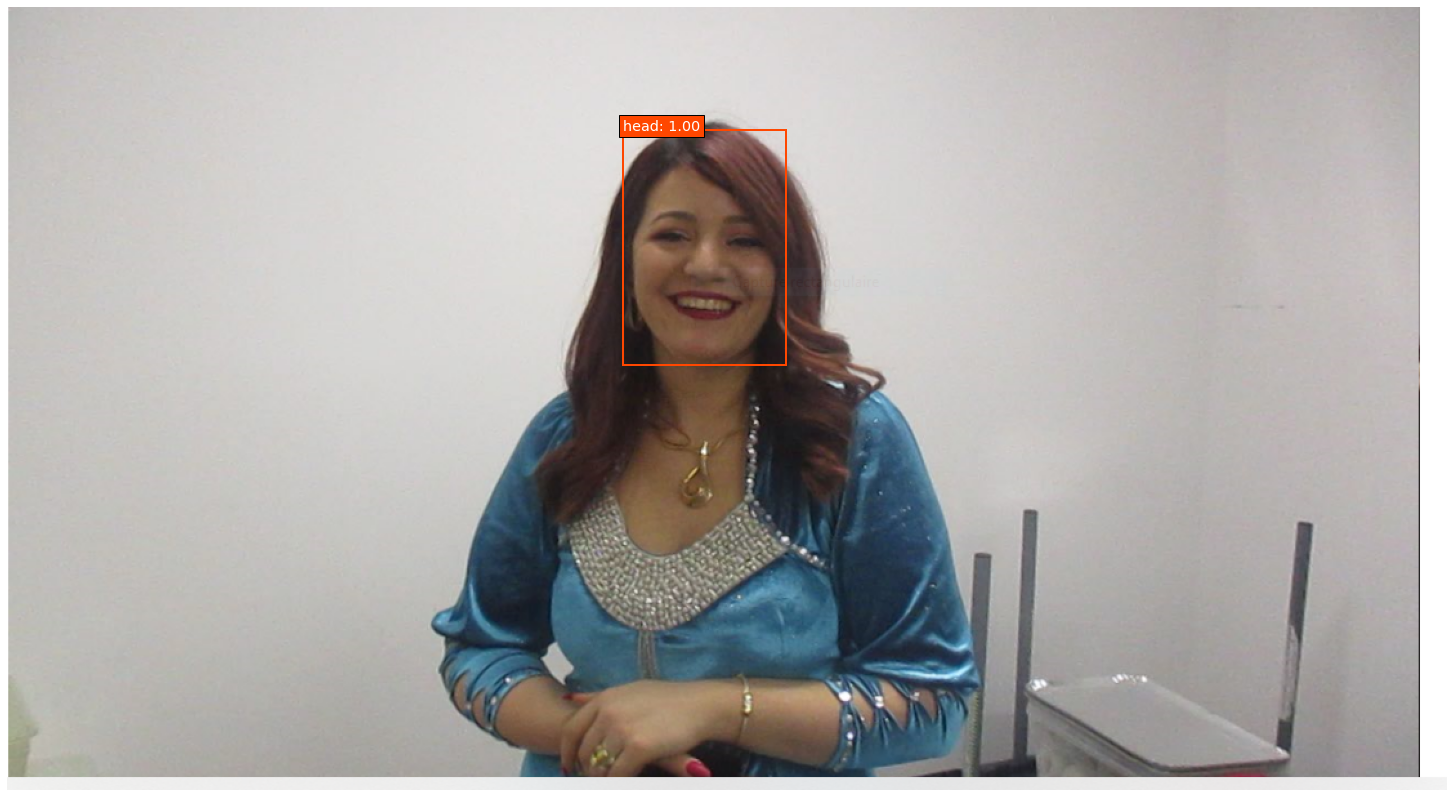

In [13]:
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'head']

# Configure plot and disable axis
fig = plt.figure(figsize=(20,12))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(orig_images[0])
current_axis = plt.gca()

# Display the image and draw the predicted boxes onto it.
for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[2] * np.array(orig_images[0]).shape[1] / img_width
    ymin = box[3] * np.array(orig_images[0]).shape[0] / img_height
    xmax = box[4] * np.array(orig_images[0]).shape[1] / img_width
    ymax = box[5] * np.array(orig_images[0]).shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [14]:
import cv2
import torch
import numpy as np
#from facenet_pytorch import MTCNN, InceptionResnetV1
#from google.colab.patches import cv2_imshow


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, model):
        self.model = model

    def _draww(self, frame, boxes, probs, landmarks):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, str(
                    prob), (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    def _draw(self, frame, boxes):
        """
        Draw landmarks and boxes for each face detected
        """
        print("In draw\n")
        #try:
            
        for box in zip(boxes[0]):
            print(box)
            # Draw rectangle on frame
            xmin =floor( box[0][2] * np.array(frame).shape[1] / img_width)
            ymin = floor(box[0][3] * np.array(frame).shape[0] / img_height)
            xmax = floor(box[0][4] * np.array(frame).shape[1] / img_width)
            ymax = floor(box[0][5] * np.array(frame).shape[0] / img_height)
            #cv2.rectangle(frame,(box[0][2], box[0][3]),(box[0][4], box[0][5]),(0, 0, 255),thickness=2)
            cv2.rectangle(frame,(xmin, ymin),(xmax, ymax),(0, 0, 255),thickness=2)
            #print("debut print box elt \n" )
            #for ex in box:
            #    print(ex)
            #print("fin print box elt\n" )
        #except:
         #   print("draw don't work")
          #  pass

        return frame
    def _drawww(self,orig_images,y_pred):
        print(np.array(orig_images[0]).shape)
        y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

        np.set_printoptions(precision=2, suppress=True, linewidth=90)
        # Set the colors for the bounding boxes
        colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
        classes = ['background', 'head']

        # Configure plot and disable axis
        fig = plt.figure(figsize=(20,12))
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(orig_images[0])
        current_axis = plt.gca()

        # Display the image and draw the predicted boxes onto it.
        for box in y_pred_thresh[0]:
            # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
            xmin = box[2] * np.array(orig_images[0]).shape[1] / img_width
            ymin = box[3] * np.array(orig_images[0]).shape[0] / img_height
            xmax = box[4] * np.array(orig_images[0]).shape[1] / img_width
            ymax = box[5] * np.array(orig_images[0]).shape[0] / img_height
            color = colors[int(box[0])]
            label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
            current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
            current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
        return np.fromstring(fig.tostring_rgb(), dtype='uint8')
    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """
        #cap = cv2.VideoCapture(0)
        cap = cv2.VideoCapture('test_video/V1.mp4')

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
       # out = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (cap.get(cv2.CAP_PROP_FRAME_WIDTH),cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        out = cv2.VideoWriter('output.mp4',-1, 18.0, (1920,1080))

        while cap.isOpened():
            ret, frame = cap.read()
            if ret==False:
                break
            #print(frame.shape)
            dim=(512,512)
            framen=cv2.resize(frame,dim)
            x=[]
            x.append(framen)
            framen=np.array(x)
            
            #boxes= self.mtcnn.predict(frame)
            print(framen.shape)
            #try:
            print("ça va")
            #print(frame.dtype)
            # detect face box, probability and landmarks
            y_pred= self.model.predict(framen)
            print(y_pred)
            y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

            np.set_printoptions(precision=2, suppress=True, linewidth=90)
            print(y_pred_thresh)
            #print(y_pred_thresh.shape) ça n'a pas passé je pense q'il n'a pas d'attribut shape
            # draw on frame
            print("call draw")
            frame=self._draw(frame,y_pred_thresh)
            #imm=self._drawww(frame,y_pred)
            #print(imm)
            #break
            #print(boxes)
            #except:
             #   print("ça ne va pas")
              #  pass

            # Show the frame
            #
            #print(frame.shape)
            #cv2.imshow("dhejdh",np.squeeze(frame))
            #cv2.waitKey(10000)
            #break
            #print(frame.shape)
            out.write(np.squeeze(frame))

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        out.release()
        cv2.destroyAllWindows()
        
        
# Run the app


In [15]:
# Run the app
ssd_head = model
# For a model pretrained on VGGFace2
#model = InceptionResnetV1(pretrained='vggface2').eval()
fcd = FaceDetector(ssd_head)
fcd.run()

(1, 512, 512, 3)
ça va
[[[  1.     0.03  62.77 392.1   89.32 447.23]
  [  1.     0.02 125.86  51.48 142.38  94.06]
  [  1.     0.02 498.55  36.85 508.2   62.55]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03  62.53 390.79  89.7  446.83]
  [  1.     0.02 125.81  51.33 142.42  94.2 ]
  [  1.     0.02 499.07  38.52 508.06  62.54]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03  62.2  390.27  89.88 446.8 ]
  [  1.     0.02 125.83  51.37 142.44  94.13]
  [  1.     0.02 498.72  37.44 508.12  62.59]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.

[[[  1.     0.04  70.61 451.51  90.81 495.22]
  [  1.     0.02 490.37  10.56 508.68  60.02]
  [  1.     0.02 125.85  51.34 142.63  94.19]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.09  70.61 450.54  90.89 495.08]
  [  1.     0.02 490.67  11.19 508.62  59.48]
  [  1.     0.02 125.81  50.65 142.7   94.47]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.08  69.63 455.11  92.54 494.49]
  [  1.     0.03 490.17   9.44 508.8   59.84]
  [  1.     0.02 125.85  50.81 142.7   94.37]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.54  49.72 143.08  94.96]
  [  1.     0.03  98.91 440.11 157.01 508.17]
  [  1.     0.02  68.21 407.54  87.22 442.13]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.57  49.71 143.08  94.91]
  [  1.     0.03  68.26 407.26  87.26 442.51]
  [  1.     0.02  95.73 437.2  152.42 505.18]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.51  49.62 143.11  95.02]
  [  1.     0.03  68.24 407.3   87.08 442.12]
  [  1.     0.02 466.52 335.92 507.89 444.82]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.15  49.48 143.51  96.13]
  [  1.     0.02  73.14 463.55  85.6  492.3 ]
  [  1.     0.02  48.18 465.4   71.85 505.41]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.13  49.49 143.51  96.11]
  [  1.     0.02 477.2  363.53 524.13 469.53]
  [  1.     0.01 119.08  51.33 134.63  86.85]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.14  49.47 143.52  96.11]
  [  1.     0.02 442.13 475.41 462.53 510.65]
  [  1.     0.02  48.31 465.01  71.98 505.39]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.06 126.43  50.24 142.81  95.2 ]
  [  1.     0.05 291.05 354.06 324.31 402.  ]
  [  1.     0.04  70.83 455.    86.44 492.01]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.09 282.57 344.9  315.14 397.2 ]
  [  1.     0.06 126.44  49.94 142.88  95.01]
  [  1.     0.06  63.08 392.43  87.79 447.76]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.07 275.09 337.47 306.09 399.51]
  [  1.     0.06 126.43  49.93 142.88  95.02]
  [  1.     0.05  62.94 391.59  88.37 448.06]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.56 215.19 271.03 240.11 332.64]
  [  1.     0.06 126.48  50.14 142.87  95.1 ]
  [  1.     0.02  62.78 391.95  88.6  448.22]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.56, 215.19, 271.03, 240.11, 332.64]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.56, 215.19, 271.03, 240.11, 332.64], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.45 208.44 257.06 233.97 321.57]
  [  1.     0.06 126.48  50.14 142.87  95.1 ]
  [  1.     0.02  62.74 392.34  88.57 447.6 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.45, 208.44, 257.06, 233.97, 321.57]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.45, 208.44, 257.06, 233.97, 321.57], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.6  206.29 251.96 230.95 315.4 ]
  [ 

[[[  1.     0.13 130.01 201.7  155.68 244.25]
  [  1.     0.07 185.15 316.74 191.19 330.95]
  [  1.     0.07 186.27 322.28 191.89 336.58]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.12 127.42 200.75 153.77 244.09]
  [  1.     0.07 180.64 311.17 188.11 330.55]
  [  1.     0.06 126.59  50.19 142.76  94.92]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.08 154.17 225.18 165.91 247.8 ]
  [  1.     0.08 122.11 202.33 147.35 246.92]
  [  1.     0.06 126.64  50.19 142.77  94.89]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.06 126.59  50.48 142.67  94.61]
  [  1.     0.02  65.06 396.31  87.66 443.01]
  [  1.     0.02 120.34  53.57 134.42  86.97]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.06 126.59  50.46 142.66  94.62]
  [  1.     0.02  65.1  396.35  87.64 443.52]
  [  1.     0.02 120.34  53.63 134.38  86.92]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.06 126.59  50.48 142.67  94.6 ]
  [  1.     0.04 110.9  232.95 117.28 248.88]
  [  1.     0.03  65.09 397.15  87.51 443.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.72  49.86 142.61  97.33]
  [  1.     0.03  62.59 393.7   87.51 447.81]
  [  1.     0.02 190.26  90.77 242.42 181.43]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.04  62.35 392.43  87.43 448.47]
  [  1.     0.03 125.62  49.62 142.74  97.68]
  [  1.     0.02   9.91 185.95  26.51 225.27]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.7   49.73 142.68  97.18]
  [  1.     0.03  62.62 393.34  87.53 448.54]
  [  1.     0.03   6.65 186.55  22.94 227.47]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.85  49.79 142.83  97.78]
  [  1.     0.02 190.39  91.42 242.91 183.2 ]
  [  1.     0.02  70.79 460.64  86.83 495.96]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.81  49.79 142.84  97.78]
  [  1.     0.03 190.24  91.27 242.79 182.45]
  [  1.     0.02  70.82 461.19  86.76 496.05]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.04 125.83  49.79 142.84  97.82]
  [  1.     0.03  70.9  460.92  87.   496.04]
  [  1.     0.02  98.04 439.18 156.78 508.06]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 200.61  36.54 247.12 101.66]
  [  1.     0.03 125.72  49.69 142.88  97.84]
  [  1.     0.03  99.03 439.83 158.7  509.09]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.04 195.05  41.53 237.95 101.47]
  [  1.     0.03  98.86 440.08 158.78 509.25]
  [  1.     0.03 125.71  49.7  142.87  97.59]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.05 195.06  41.48 237.66 104.18]
  [  1.     0.03  98.78 439.99 158.98 509.17]
  [  1.     0.03 125.69  49.65 142.88  97.56]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.1  197.98  97.23 225.5  157.57]
  [  1.     0.04  47.28 373.36  88.88 443.2 ]
  [  1.     0.03  70.36 458.13  93.28 499.21]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.1  198.99  94.74 224.84 160.17]
  [  1.     0.06 199.09  63.26 214.65 111.52]
  [  1.     0.03  47.07 372.85  88.75 442.5 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.07 199.65  67.36 214.06 108.02]
  [  1.     0.04 126.35  50.78 142.38  97.94]
  [  1.     0.03 205.55  73.67 217.27 107.26]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.12 126.63  50.99 142.55  94.32]
  [  1.     0.04  60.74 388.22  88.71 447.27]
  [  1.     0.03 239.93 102.96 252.72 131.04]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.12 126.58  50.9  142.57  94.35]
  [  1.     0.09 214.33  99.45 252.95 187.92]
  [  1.     0.04  62.7  393.54  88.26 446.41]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.15 217.43  99.55 255.96 194.58]
  [  1.     0.12 126.51  50.77 142.64  94.51]
  [  1.     0.04 247.32 105.28 259.14 137.73]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.09 128.15 185.62 150.98 242.58]
  [  1.     0.08 126.14  49.71 143.04  95.93]
  [  1.     0.04 243.06 160.16 275.37 228.09]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.13 130.01 189.27 152.53 243.9 ]
  [  1.     0.09 126.07  49.38 142.96  95.41]
  [  1.     0.07 243.67 162.22 274.03 224.79]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.13 130.63 189.39 153.63 244.16]
  [  1.     0.1  243.97 163.84 274.27 225.16]
  [  1.     0.1  126.13  49.48 142.97  95.58]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.9  244.96 166.27 275.17 223.35]
  [  1.     0.79 185.78 151.65 208.95 212.96]
  [  1.     0.06 208.12 268.33 229.93 309.74]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.9 , 244.96, 166.27, 275.17, 223.35],
       [  1.  ,   0.79, 185.78, 151.65, 208.95, 212.96]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.9 , 244.96, 166.27, 275.17, 223.35], dtype=float32),)
(array([  1.  ,   0.79, 185.78, 151.65, 208.95, 212.96], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.96 189.6  155.78 212.92 203.17]
  [  1.     0.91 244.88 166.48 275.57 222.91]
  [  1.     0.05 126.55  50.39 142.41  93.69]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.96, 189.6 , 155.78, 212.92, 203.17],
       [  1.  ,   0.91, 244.88, 166.48, 275.57, 222.

[[[  1.     0.66 257.39 189.08 282.05 233.85]
  [  1.     0.14 198.87 156.4  216.18 207.57]
  [  1.     0.05 265.56 187.23 275.98 202.4 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.66, 257.39, 189.08, 282.05, 233.85]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.66, 257.39, 189.08, 282.05, 233.85], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.59 260.31 193.6  285.76 241.45]
  [  1.     0.06 200.29 163.85 215.25 209.29]
  [  1.     0.03 265.9  190.74 277.94 210.36]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.59, 260.31, 193.6 , 285.76, 241.45]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.59, 260.31, 193.6 , 285.76, 241.45], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.48 263.42 200.64 291.28 255.29]
  [ 

[[[  1.     0.59 296.25 314.51 329.52 376.24]
  [  1.     0.08 201.57 256.79 227.43 332.47]
  [  1.     0.03 125.64  49.18 143.    95.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.59, 296.25, 314.51, 329.52, 376.24]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.59, 296.25, 314.51, 329.52, 376.24], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.37 297.71 330.71 331.97 396.44]
  [  1.     0.18 202.98 260.69 227.46 332.74]
  [  1.     0.03 125.64  49.18 143.    95.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.37, 297.71, 330.71, 331.97, 396.44]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.37, 297.71, 330.71, 331.97, 396.44], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.48 297.43 345.23 332.45 407.69]
  [ 

[[[  1.     0.53 293.49 269.65 319.13 343.14]
  [  1.     0.03 125.98  49.35 143.52  96.04]
  [  1.     0.02 170.59 481.26 192.17 512.8 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.53, 293.49, 269.65, 319.13, 343.14]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.53, 293.49, 269.65, 319.13, 343.14], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.78 301.58 268.75 327.49 339.93]
  [  1.     0.03 125.99  49.31 143.53  95.93]
  [  1.     0.02 178.54 484.51 200.02 514.05]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.78, 301.58, 268.75, 327.49, 339.93]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.78, 301.58, 268.75, 327.49, 339.93], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.87 305.12 265.89 331.62 338.09]
  [ 

[[[  1.     0.03 347.75 367.21 356.   385.94]
  [  1.     0.02 374.44 287.96 401.93 352.38]
  [  1.     0.02 358.93 353.74 363.24 364.34]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 347.92 367.75 356.08 385.44]
  [  1.     0.02 362.06 353.95 366.2  363.86]
  [  1.     0.02 442.94 477.92 463.02 510.43]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.06 351.68 369.44 359.14 384.63]
  [  1.     0.03 384.89 283.65 425.55 381.35]
  [  1.     0.03 411.09 292.03 429.69 351.69]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.13 410.73 212.65 446.65 314.98]
  [  1.     0.02 126.3   52.34 143.08  94.83]
  [  1.     0.02 442.57 474.63 463.12 510.11]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.07 412.93 209.   450.28 311.5 ]
  [  1.     0.03 126.63  52.57 142.81  94.1 ]
  [  1.     0.02 118.85  55.26 133.03  86.25]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 412.3  209.62 450.59 316.38]
  [  1.     0.03 401.99 293.51 412.   314.76]
  [  1.     0.03 126.72  52.75 142.69  93.86]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 126.27  52.55 142.84  95.08]
  [  1.     0.02 119.94  17.62 375.38 462.38]
  [  1.     0.02 119.45  55.47 133.2   86.17]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.28  52.51 142.81  94.97]
  [  1.     0.02 119.42  55.54 133.15  86.15]
  [  1.     0.02  73.87 449.49 114.28 509.42]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.19  52.37 142.86  94.99]
  [  1.     0.02 119.47  55.54 133.26  86.16]
  [  1.     0.02 483.85 181.54 492.12 200.87]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 479.29 268.72 486.34 282.43]
  [  1.     0.03 126.34  52.33 142.97  94.99]
  [  1.     0.03 480.25 266.36 485.59 275.89]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 479.91 270.68 486.26 282.57]
  [  1.     0.03 126.35  52.35 142.97  94.99]
  [  1.     0.02 477.98 272.53 485.5  288.78]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.05 482.61 269.19 490.61 283.97]
  [  1.     0.03 126.34  52.35 142.97  95.  ]
  [  1.     0.02 482.5  267.99 486.72 275.39]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 191.42  92.33 240.53 179.52]
  [  1.     0.02 125.66  48.89 142.39  90.26]
  [  1.     0.02 443.14 478.11 463.21 510.61]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 191.88  91.43 240.73 181.21]
  [  1.     0.02 125.65  48.88 142.39  90.27]
  [  1.     0.02 446.4  327.71 451.52 337.65]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 191.59  91.88 240.63 180.35]
  [  1.     0.02 443.31 324.1  451.56 338.94]
  [  1.     0.02 125.65  48.91 142.4   90.24]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 469.77 210.87 475.44 225.63]
  [  1.     0.02 190.93  91.64 241.43 177.13]
  [  1.     0.02 494.01 141.56 505.21 170.27]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 468.54 209.67 474.75 225.38]
  [  1.     0.01 125.4   48.21 142.73  90.89]
  [  1.     0.01 190.83  91.58 241.4  177.41]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 491.53 162.17 505.18 186.83]
  [  1.     0.02 467.84 207.71 474.73 224.74]
  [  1.     0.01 125.4   48.2  142.73  90.89]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 191.62  90.   241.   179.5 ]
  [  1.     0.02 155.89 485.98 175.48 514.58]
  [  1.     0.02 164.01 486.3  183.39 514.68]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03  47.22 437.69  70.31 496.25]
  [  1.     0.02 164.3  487.29 182.95 513.9 ]
  [  1.     0.02 191.51  90.09 240.93 179.27]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 191.32  90.24 240.97 178.65]
  [  1.     0.01 163.57 486.2  183.44 514.33]
  [  1.     0.01  48.2  466.28  71.81 507.19]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 191.67  90.82 240.42 179.53]
  [  1.     0.02 416.06 385.25 580.94 601.4 ]
  [  1.     0.02 401.96 221.3  421.67 277.33]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 191.86  90.5  240.75 179.66]
  [  1.     0.02 417.09 385.04 580.68 601.55]
  [  1.     0.02 477.16 363.64 523.79 468.51]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 192.1   90.64 241.06 180.72]
  [  1.     0.02 416.35 384.98 580.55 601.45]
  [  1.     0.01 487.97 308.05 504.03 339.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.42 365.93 150.58 385.24 206.3 ]
  [  1.     0.02 126.07  49.15 142.59  90.64]
  [  1.     0.02 132.31   9.07 148.73  33.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.42, 365.93, 150.58, 385.24, 206.3 ]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.42, 365.93, 150.58, 385.24, 206.3 ], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.05 357.72 141.24 379.94 203.32]
  [  1.     0.02 126.07  49.15 142.59  90.63]
  [  1.     0.02 132.31   9.07 148.73  33.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.19 352.72 142.54 376.49 195.2 ]
  [  1.     0.02 126.07  49.15 142.59  90.63]
  [  1.     0.02 132.31   9.07 148.73  33.31]
  ...
  [  0.     0.

[[[  1.     0.17 298.24 135.68 318.78 196.56]
  [  1.     0.02 306.1  132.25 316.52 153.6 ]
  [  1.     0.02 125.98  48.87 142.72  90.95]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.41 292.46 135.35 315.88 193.49]
  [  1.     0.02 125.98  48.89 142.72  90.93]
  [  1.     0.02 132.29   9.02 148.74  33.34]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.41, 292.46, 135.35, 315.88, 193.49]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.41, 292.46, 135.35, 315.88, 193.49], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.61 287.14 135.74 309.57 192.43]
  [  1.     0.02 298.54 213.81 319.52 277.48]
  [  1.     0.02 125.98  48.88 142.72  90.93]
  ...
  [  0.     0.

[[[  1.     0.12 242.82 148.97 260.39 203.08]
  [  1.     0.02 250.66 146.22 259.31 162.27]
  [  1.     0.02 125.96  48.9  142.71  91.04]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.2  237.3  146.36 255.04 207.14]
  [  1.     0.03 235.94 238.03 239.69 250.47]
  [  1.     0.02 125.96  48.9  142.71  91.04]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.15 235.02 146.25 252.89 200.59]
  [  1.     0.06 245.16 145.06 250.96 156.21]
  [  1.     0.02 125.96  48.89 142.71  91.03]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 189.25 142.64 207.29 194.97]
  [  1.     0.02 125.96  48.88 142.69  90.98]
  [  1.     0.02 466.33 335.9  507.7  446.62]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.16 187.5  142.88 206.09 196.88]
  [  1.     0.02 125.96  48.89 142.69  90.97]
  [  1.     0.02 132.27   9.01 148.75  33.36]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 184.44 143.91 205.12 201.48]
  [  1.     0.02 466.24 335.94 507.74 446.3 ]
  [  1.     0.02 125.96  48.92 142.69  90.96]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.07 137.73 178.96 160.35 240.15]
  [  1.     0.02 126.41  50.9  143.07  95.  ]
  [  1.     0.02 466.39 335.83 507.96 445.82]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.14 136.75 175.81 156.26 230.95]
  [  1.     0.02 126.42  50.97 143.07  94.97]
  [  1.     0.02 466.58 336.47 507.66 446.48]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.17 136.11 174.72 156.46 231.65]
  [  1.     0.02 126.44  51.08 143.08  94.97]
  [  1.     0.02 466.48 336.18 507.84 447.05]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 107.47 182.11 126.85 215.99]
  [  1.     0.02 126.41  50.86 143.11  95.08]
  [  1.     0.02 103.41 187.33 119.19 217.59]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 114.44 173.54 124.61 193.49]
  [  1.     0.02 126.41  50.85 143.12  95.08]
  [  1.     0.02 466.25 335.77 507.81 446.71]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 113.2  174.5  125.77 202.01]
  [  1.     0.02 126.39  50.91 143.12  95.13]
  [  1.     0.02 106.99 175.78 127.1  212.13]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 126.27  50.22 143.4   95.2 ]
  [  1.     0.02 119.57  53.06 133.75  86.16]
  [  1.     0.02 477.14 363.05 524.29 469.08]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 126.4   50.31 143.54  94.93]
  [  1.     0.02 119.56  52.99 133.78  86.25]
  [  1.     0.02 477.23 362.8  524.14 469.52]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 128.51  46.15 146.73 102.9 ]
  [  1.     0.02 163.11 483.84 183.49 513.19]
  [  1.     0.02 119.48  52.91 133.79  86.35]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.02 126.6   49.4  142.71  89.84]
  [  1.     0.02 466.49 335.95 507.76 446.17]
  [  1.     0.02 477.12 363.   524.12 469.02]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 126.62  49.49 142.68  89.84]
  [  1.     0.02 162.37 482.23 184.44 513.61]
  [  1.     0.02 466.68 337.06 507.84 446.52]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.02 126.62  49.44 142.7   89.79]
  [  1.     0.02 466.55 336.33 507.83 445.98]
  [  1.     0.02 477.16 362.97 524.1  468.72]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 126.42  50.84 142.12  93.93]
  [  1.     0.03 100.27 203.29 105.69 216.25]
  [  1.     0.02 120.88  53.79 134.52  86.72]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.42  50.93 142.14  94.05]
  [  1.     0.03 102.68 216.14 106.62 225.6 ]
  [  1.     0.02 120.8   53.73 134.52  86.74]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.04 103.43 216.62 107.07 225.3 ]
  [  1.     0.03 109.05  17.27 368.09 462.68]
  [  1.     0.03 126.39  50.86 142.14  94.14]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 126.47  50.87 142.18  93.78]
  [  1.     0.02 120.68  53.62 134.38  86.64]
  [  1.     0.02 466.74 335.54 507.86 447.2 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.47  50.87 142.18  93.78]
  [  1.     0.02 120.68  53.62 134.38  86.64]
  [  1.     0.02 466.65 335.51 507.97 447.22]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.47  50.87 142.18  93.78]
  [  1.     0.02 120.68  53.6  134.38  86.64]
  [  1.     0.02 131.81   8.45 149.29  33.84]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 126.42  50.82 142.19  93.88]
  [  1.     0.02 396.83 317.16 420.12 389.45]
  [  1.     0.02 120.66  53.64 134.43  86.78]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.42  50.83 142.19  93.89]
  [  1.     0.02 120.66  53.64 134.42  86.79]
  [  1.     0.02  73.63 448.   111.96 506.06]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.5   50.82 142.19  93.73]
  [  1.     0.02  73.65 447.93 111.93 507.04]
  [  1.     0.02 120.7   53.75 134.45  86.71]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 103.7  181.07 117.43 210.67]
  [  1.     0.03 126.53  50.96 142.17  93.67]
  [  1.     0.02 120.68  53.81 134.45  86.74]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.53  50.95 142.17  93.67]
  [  1.     0.02  74.51 448.12 113.45 506.93]
  [  1.     0.02 111.82 188.73 120.76 211.21]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.54  50.97 142.17  93.67]
  [  1.     0.03 110.73 182.47 121.03 210.04]
  [  1.     0.02  74.38 447.8  113.58 506.48]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.37 160.22 118.08 188.17 165.01]
  [  1.     0.05 140.81 274.21 162.87 305.81]
  [  1.     0.03 126.18  50.04 142.89  94.62]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([[  1.  ,   0.37, 160.22, 118.08, 188.17, 165.01]], dtype=float32)]
call draw
In draw

(array([  1.  ,   0.37, 160.22, 118.08, 188.17, 165.01], dtype=float32),)
(1, 512, 512, 3)
ça va
[[[  1.     0.06 169.77 209.08 191.34 268.24]
  [  1.     0.03 126.22  50.09 142.86  94.55]
  [  1.     0.03 136.34 193.05 163.01 259.6 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.22  50.1  142.86  94.54]
  [  1.     0.03 172.94 126.14 196.   165.52]
  [  1.     0.02 119.56  52.72 134.13  86.87]
  ...
  [  0.     0.

[[[  1.     0.08 243.23 118.17 260.84 174.02]
  [  1.     0.03 126.23  49.9  143.    94.76]
  [  1.     0.03 247.88 116.59 255.04 131.  ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.06 246.27 116.04 262.89 169.76]
  [  1.     0.05 250.91 113.9  259.44 129.71]
  [  1.     0.04 152.54 251.28 199.77 326.07]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.11 249.16 112.67 268.43 175.  ]
  [  1.     0.05 254.72 111.13 262.88 127.61]
  [  1.     0.03 154.83 249.37 199.9  325.75]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.08 319.48 114.67 333.44 157.64]
  [  1.     0.03 126.16  49.54 143.21  94.88]
  [  1.     0.03 323.12 100.15 332.36 119.38]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.99  49.28 143.32  95.16]
  [  1.     0.03 321.57 121.1  335.48 158.53]
  [  1.     0.02 304.6  133.26 327.06 190.54]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 126.05  49.29 143.28  95.05]
  [  1.     0.02 312.36 128.62 334.17 181.08]
  [  1.     0.02 477.38 363.15 524.35 469.68]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.09 371.85 141.55 390.36 190.06]
  [  1.     0.03 125.8   48.6  143.45  95.49]
  [  1.     0.01 397.36 317.11 419.62 387.97]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.78  48.55 143.48  95.58]
  [  1.     0.03 373.42 144.16 390.9  187.74]
  [  1.     0.03 397.03 317.98 419.38 388.12]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.06 378.95 141.65 396.84 188.95]
  [  1.     0.03 125.85  48.63 143.43  95.47]
  [  1.     0.03 373.87 144.24 390.18 184.31]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 126.    51.7  142.63  93.69]
  [  1.     0.02 118.76  52.89 133.81  87.06]
  [  1.     0.01 446.27 -72.35 543.56 132.03]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.96  51.74 142.63  93.72]
  [  1.     0.02 118.74  52.88 133.82  87.1 ]
  [  1.     0.02  48.04 466.7   71.82 507.21]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[   1.      0.03  125.88   51.6   142.63   93.69]
  [   1.      0.02  118.66   52.48  133.88   87.02]
  [   1.      0.01  419.7  -103.89  541.21  203.73]
  ...
  [   0.      0.      0.      0.      0.      0.  ]
  [   0.      0.      0.      0.      0.      0.  ]


[[[  1.     0.03 125.94  51.65 142.83  93.94]
  [  1.     0.02 121.67  16.97 373.15 459.51]
  [  1.     0.02 118.62  53.05 133.73  87.14]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.95  51.71 142.82  93.87]
  [  1.     0.02 118.61  53.08 133.72  87.14]
  [  1.     0.02 416.23 385.32 580.81 601.03]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.94  51.65 142.82  93.9 ]
  [  1.     0.02 118.61  53.01 133.73  87.21]
  [  1.     0.02 471.1  147.77 481.39 169.4 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.46  51.4  143.36  94.99]
  [  1.     0.02 489.53   6.84 509.46  61.09]
  [  1.     0.02 118.27  52.81 133.89  87.15]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.45  51.45 143.35  94.97]
  [  1.     0.02 489.48   7.17 509.43  60.89]
  [  1.     0.02  75.8  455.56 115.64 511.48]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.35  51.19 143.39  95.13]
  [  1.     0.02  73.8  448.48 111.22 506.41]
  [  1.     0.02 396.89 317.23 420.2  387.6 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  

[[[  1.     0.03 125.59  51.04 143.41  95.11]
  [  1.     0.02 488.   125.39 508.68 182.15]
  [  1.     0.02 118.25  52.72 133.89  87.1 ]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.57  50.95 143.45  95.15]
  [  1.     0.02 489.09 130.28 508.35 179.45]
  [  1.     0.02 118.23  52.66 133.89  87.07]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]]]
[array([], shape=(0, 6), dtype=float32)]
call draw
In draw

(1, 512, 512, 3)
ça va
[[[  1.     0.03 125.83  51.71 143.12  94.4 ]
  [  1.     0.02 490.99 132.13 508.91 181.52]
  [  1.     0.02 442.84 291.71 453.7  305.49]
  ...
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.     0.     0.  ]
  [  0.     0.     0.     0.  